In [1]:
import os
import pickle as pkl
from src.model.mula_tabpro.agent import Cleaner, ViewGenerator, NL2SQLer, Imputater
from src.dataset import TQADataset
from global_values import *
from src.model.mula_tabpro.base import *
import sqlite3
from src.llm.gpt_inference import GPTPOOL
from src.tools.utils import post_process_sql
from src.tools.sql_executor import SQLExecutor
from src.tools.binder_utils.evaluator import Evaluator

# conn = sqlite3.connect('./tmp/test.db')

# if os.path.exists('tmp/wiki_qa.pkl'):
#     ds = pkl.load(open('tmp/wiki_qa.pkl', 'rb'))
# else:
#     ds = TQADataset(dataset_name='wiki_qa')
#     ds.load_data()
#     with open('tmp/wiki_qa.pkl', 'wb') as f:
#         pkl.dump(ds, f)

# sql_exe = SQLExecutor()
# gpt = GPTPOOL(model='deepseek-coder')
gpt = GPTPOOL(model='deepseek-coder')
output = gpt.query("""Given the table saved in file data.csv, read it with pandas. Here is example rows:

Date | Cyclist | Medal | age
02-28 | Alej(ESP) | "3" | "35"
01/01 | Dav. ITA | "2" | "28"
02/22 | Alex.(ITA) | "2*" | "28"
03/15 | Juan(ARG) | "1" | "30"
04/05 | Maria(FRA) | "3" | "25"
05/10 | Carlos(BRA) | "2" | "29"
06/18 | Sofia(GER) | "1" | "27"
07/22 | Pedro(POR) | "2*" | "31"
08/30 | Ana(ESP) | "3" | "26"
09/12 | Luca(ITA) | "1" | "28"
10/25 | Clara(USA) | "2" | "32"
11/08 | Miguel(MEX) | "3" | "29"
12/14 | Laura(CAN) | "1" | "24"

Question: which country has the most medals in total in February?

To answer the question, we can generate SQL. But before that, please generate python code to process the table (notice, donot generate code to answer the question)""")

HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


In [2]:
print(output)

Certainly! Below is the Python code to read the `data.csv` file into a pandas DataFrame and process it. This code will read the CSV file, clean the data, and prepare it for further analysis.

```python
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('data.csv', delimiter='|')

# Remove leading/trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Clean the 'Date' column to ensure it's in a consistent format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d', errors='coerce')

# Extract the country code from the 'Cyclist' column
df['Country'] = df['Cyclist'].str.extract(r'\((.*?)\)')

# Clean the 'Medal' column to remove any special characters
df['Medal'] = df['Medal'].str.replace(r'[*]', '', regex=True)

# Convert 'Medal' and 'age' columns to numeric
df['Medal'] = pd.to_numeric(df['Medal'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Filter rows where 'Date' is in February
df_february = df[df['Date'].d

In [1]:
from Levenshtein import ratio
ratio('please standardize the column `date` to datetime format.',  'please standardize the column `no` to numerical format.')

0.8288288288288288

In [4]:
import pickle as pkl
df = pkl.load(open(fr'D:\0th-D\MulA_Tabpro\tmp\outputs\mula_tabpro_v3.1.22-tableqa-deepseek-chat-False-LEVEN_RATION_-1_ablation_study_G_C_I_processed_data.pkl', 'rb'))
data_dic = {d.id: d for d in df}
df_dic = {d.id: d.tbl for d in df}
pkl.dump(df_dic, open(fr'D:\0th-D\MulA_Tabpro\df_dict.pkl', 'wb'))

In [140]:
root = fr'D:\1th-D\Firefly\RAG_LLM_DM\data\TQA\wiki_qa'
save_root = fr'D:\1th-D\Firefly\RAG_LLM_DM\data\TQA\wiki_qa\processed_data'
os.path.exists(root)

True

In [141]:
df = pd.read_csv(os.path.join(root, 'test_unseen.csv'))
for i, row in df.iterrows():
    id = row['id']
    table = row['table']
    subroot = table.split('/')[:-1]
    filename = table.split('/')[-1]
    tsv_filename = filename.replace('.csv', '.tsv')

    tbl = data_dic[id].tbl

    fileroot = copy.deepcopy(save_root)
    for dir in subroot:
        fileroot = os.path.join(fileroot, dir)

    if not os.path.exists(fileroot):
        os.makedirs(fileroot)
    
    tbl.to_csv(os.path.join(fileroot, tsv_filename), sep='\t', index=False)
    tbl.to_csv(os.path.join(fileroot, filename), index=False)

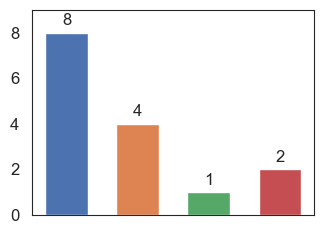

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = ['unstandardized columns', 'missing columns', 'reasoning failure', 'SQL grammar limit']
values = [8, 4, 1, 2]

sns.set(style="white")

plt.figure(figsize=(3.4, 2.5)) 
bars = plt.bar(categories, values, color=sns.color_palette("deep", 4), width=0.6, label=categories) 

# plt.xlabel('Categories', fontsize=14, fontweight='bold')
# plt.ylabel('Error Number', fontsize=14, fontweight='bold')

plt.grid(False)

max_value = max(values)
plt.ylim(0, max_value + 1)  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, round(yval, 2),
             ha='center', va='bottom', fontsize=12)

plt.xticks([])
plt.yticks(fontsize=12)

plt.gca().set_facecolor('white')

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.8) 

# plt.legend(fontsize=10, title_fontsize=12)

plt.tight_layout()
# plt.show()
# save as pdf
plt.savefig('error_distribution_tabfact.pdf', format='pdf')

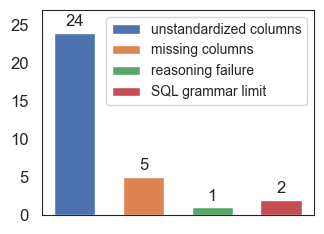

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = ['unstandardized columns', 'missing columns', 'reasoning failure', 'SQL grammar limit']
values = [24, 5, 1, 2]

sns.set(style="white")

plt.figure(figsize=(3.4, 2.5)) 
bars = plt.bar(categories, values, color=sns.color_palette("deep", 4), width=0.6, label=categories)  # 调整柱子宽度为 0.6

# plt.xlabel('Categories', fontsize=14, fontweight='bold')
# plt.ylabel('Error Number', fontsize=14, fontweight='bold')

plt.grid(False)

max_value = max(values)
plt.ylim(0, max_value + 3)  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2),
             ha='center', va='bottom', fontsize=12)

plt.xticks([])
plt.yticks(fontsize=12)

plt.gca().set_facecolor('white')

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.8) 

plt.legend(fontsize=10, title_fontsize=12)

plt.tight_layout()  
# plt.show()
# save as pdf
plt.savefig('error_distribution_wikitq.pdf', format='pdf')

In [4]:
gpt = GPTPOOL(model=LLM_NAME)
gpt.query('who are you? what is your version. What your newest date due to')

HTTP Request: POST https://35.aigcbest.top/v1/chat/completions "HTTP/1.1 200 OK"


'I am an AI language model created by OpenAI, known as GPT-3. As an AI, I don\'t have a specific version number like software would, but I am based on the most recent version of the GPT (Generative Pre-trained Transformer) technology developed by OpenAI. The current version of GPT-3 was released in June 2020.\n\nAs for my newest update or "date due to," unfortunately, I am not privy to the specific details of my updates or release schedule. OpenAI periodically makes updates and improvements to their models, but I don\'t have information on the exact dates for those updates.'

In [12]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

Load pretrained SentenceTransformer: sentence-transformers/bert-base-nli-mean-tokens
Use pytorch device: cpu


In [ ]:
from joblib import Parallel, delayed
import pickle as pkl
import os
import json



In [5]:
from src.model.mula_tabpro.prompt import *

In [ ]:
# All Checked
demo = IMPUTATER_PROMPT[f"demo_{NAMES['STAND_NUMERICAL']}"]
for t in demo.split('\n\n')[:]:
    print(t.strip())
    print('--------------------------------')

In [1]:
import pandas as pd
import pycountry_convert as pc

In [2]:
from dataprep.clean import clean_country
clean_country(df, "country", input_format="alpha-3")

CN
AS


In [15]:
def format_datetime(col:str, func):
    pass

format_datetime(col="Date", format="%m-%d")

        Date     Cyclist  Medal  age Country
0 1900-02-28   Alej(ESP)    NaN   35     ESP
1        NaT    Dav. ITA    2.0   28    None
2 1900-02-22  Alex.(ITA)    2.0   28     ITA


C:\Users\fmh\AppData\Local\Temp\ipykernel_35852\4272786614.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Medal'] = df['Medal'].str.replace('"', '').str.replace('*', '').astype(float)


In [ ]:
import re
import pandas as pd

df = pd.DataFrame(
    {
        "Date": ["02-28", "01-01", "02/22"],
        "Cyclist": ["Alej(ESP)", "Dav. ITA", "Alex.(ITA)"],
        "Medal": ['"3"', '"2"', '"2*"'],
        "age": ["35", "28", "28"],
    }
)

dates = pd.to_datetime(['12/01', '2021/12/02', '2021/12/03'])
print(dates)

In [4]:
import re
import pandas as pd


# 1. 数据准备操作多余
# 2. 数据准备操作不全：month提取之前需要先对date进行格式化
# 3. 数据准备操作生成错误
# 4. 数据准备操作中参杂reasoning步骤

# 不精准
# 质量差
# 做了除数据准备外的操作

# Date | Cyclist | Medal | age
# 02-28 | Alej(ESP) | "3" | "35"
# Jan. 1st | Dav. ITA | "2" | "28"
# 02/22 | Alex.(ITA) | "2*" | "28"
df = pd.DataFrame(
    {
        "Date": ["02-28", "Jan. 1st", "02/22"],
        "Cyclist": ["Alej(ESP)", "Dav. ITA", "Alex.(ITA)"],
        "Medal": ['"3"', '"2"', '"2*"'],
        "age": ["35", "28", "28"],
    }
)

import pandas as pd
df = pd.read_csv("data.csv")

# Cast 'Medal' and 'age' to numeric
df["Medal"] = df["Medal"].str.replace('"', "").str.strip()

df["age"] = pd.to_numeric(df["age"].str.strip(), errors="coerce")

# Extract the month from the 'Date' column
df["Month"] = pd.to_datetime(df["Date"], format="%m-%d").dt.month

# Filter for February (month 2)
feb_df = df[df["Month"] == 2]
# Extract country from the 'Cyclist' column
feb_df["Country"] = feb_df["Cyclist"].str.extract(r"\((.*?)\)")[0]

df

,Date,Cyclist,Medal,age,Month
0,02-28,Alej(ESP),3,35,NaN
1,Jan. 1st,Dav. ITA,2,28,NaN
2,02/22,Alex.(ITA),2*,28,NaN


In [2]:
gpt = GPTPOOL(model='o1-preview-2024-09-12')
gpt.query('who are you?')

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"I'm an AI language model here to help answer your questions and provide information on a wide range of topics. How can I assist you today?"

In [9]:
from openai import OpenAI
client = OpenAI()
completion = client.chat.completions.create(
    model='o1-preview-2024-09-12',
    messages=[
        {"role": "user", "content": """【Original Table】:
Ship | Type of Vessel | Lake | Location | Lives lost
---|---|---|---|---
"Argus" | "Steamer" | "Lake Huron" | "25 miles off Kincardine, Ontario" | "25 lost"
"James Carruthers" | "Steamer" | "Lake Huron" | "near Kincardine" | "18 lost"
"Hydrus" | "Steamer" | "Lake Huron" | "near Lexington, Michigan" | "28 lost"
"Leafield" | "Steamer" | "Lake Superior" | nan | "all hands"
"John A. McGean" | "Steamer" | "Lake Huron" | "near Goderich, Ontario" | "28 lost"
"Plymouth" | "Barge" | "Lake Michigan" | nan | "7 lost"
"Charles S. Price" | "Steamer" | "Lake Huron" | "near Port Huron, Michigan" | "28 lost"
"Regina" | "Steamer" | "Lake Huron" | "near Harbor Beach, Michigan" | nan
"Issac M. Scott" | "Steamer" | "Lake Huron" | "near Port Elgin, Ontario" | "28 lost"
"Henry B. Smith" | "Steamer" | "Lake Superior" | nan | "all hands"
"Wexford" | "Steamer" | "Lake Huron" | "north of Grand Bend, Ontario" | "all hands"
"Lightship No. 82" | "Lightship" | "Lake Erie" | "Point Albino (near Buffalo)" | "6 lost"
【Question】: how many more ships were wrecked in lake huron than in erie?"""}
    ]
)


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [10]:
print(completion.choices[0].message.content)

To determine how many more ships were wrecked in Lake Huron than in Lake Erie based on the provided table, we'll count the number of ships listed under each lake.

**Ships wrecked in Lake Huron:**

1. "Argus"
2. "James Carruthers"
3. "Hydrus"
4. "John A. McGean"
5. "Charles S. Price"
6. "Regina"
7. "Issac M. Scott"
8. "Wexford"

**Total ships in Lake Huron:** 8

**Ships wrecked in Lake Erie:**

1. "Lightship No. 82"

**Total ships in Lake Erie:** 1

**Calculating the difference:**

Number of ships wrecked in Lake Huron\
− Number of ships wrecked in Lake Erie\
= 8 − 1\
= **7**

**Answer:** 7


In [ ]:
from openai import OpenAI

ask = 'hello, who are you?'
client = OpenAI()
completion = client.chat.completions.create(
    model=
    messages=[{
        "role": "system", "content": "Assistant is an intellectual chatbot designed to follow you instructions."
    }, {"role": "user", "content": ask}],
    max_tokens=MAX_OUTPUT_LIMIT
)
completion

In [ ]:
import re

def get_related_cols(func:str):
    var = re.findall(r'lambda (.*?):', func)[0]
    finds = re.findall(rf'{var}\[\'(.*?)\'\]', func) + re.findall(rf'{var}\[\"(.*?)\"\]', func)
    print(var,rf'{var}\[\'(.*?)\'\]')
    return finds

s = """ ```generate_new_column(df, new_column="duration_of_role", func=lambda x: int(str(x['year']).split('-')[1].split('[')[0]) - int(str(x['year']).split('-')[0]) if '-' in str(x['year']) else 1)```"""
get_related_cols(s)[1]

In [ ]:
col_str = '`col1`, `col2`, `col3`'
cols = col_str.split('`')[1::2]
cols

In [ ]:
from datetime import datetime

datetime.strptime("36.54", "%M:%S.%f").strftime("%S.%f")

In [2]:
# load pkl
origin_data = pkl.load(open(r'D:\0th-D\MulA_Tabpro\tmp\tablefact_-1.pkl', 'rb'))
processed_data = pkl.load(open(r'D:\0th-D\MulA_Tabpro\tmp\outputs\mula_tabpro_v3.1.1-tablefact-deepseek-chat_-1_data_prep_processed_data.pkl', 'rb'))

In [ ]:
test_unseen = pd.read_csv(r'D:\0th-D\Firefly\RAG_LLM_DM\data\TQA\wiki_qa\test_unseen.csv')
# set id as index
test_unseen.set_index('id', inplace=True)
# 提取 id 为 nu-1 的行
test_unseen.loc['nu-1']

In [35]:
items = []
for df in processed_data:
    id = df.id
    table_id = f'table-{id}'

    tbl = df.tbl # pd.dataframe
    # tbl.to_csv(f'D:/0th-D/Firefly/RAG_LLM_DM/data/TFV/exp/processed_csv/{table_id}.csv', index=False)

    header = tbl.columns.tolist()
    rows = tbl.values.tolist()
    caption = df.caption
    page_title = df.title
    statement = df.question
    label = df.label
    hardness = 'complex'
    small_test = False
    question = df.question
    answer_text = df.label

    it = {
        'id': id,
        'table': {
            'id': table_id,
            'header': header,
            'rows': [[str(cell) for cell in row] for row in rows],
            'caption': caption,
        },
        'statement': statement,
        'label': label,
        'hardness': hardness,
        'small_test': small_test,
    }
    # print(it)
    # print()
    # print()

    items.append(it)

pkl.dump(items, open(r'D:\0th-D\Firefly\RAG_LLM_DM\data\TFV\exp\processed_data.pkl', 'wb'))

In [ ]:
save_root = r'D:\0th-D\Firefly\RAG_LLM_DM\data\TQA\processed_wiki_qa\test'

In [ ]:
for df in processed_data:
    id = df.id
    tbl = df.tbl
    col_type = df.col_type
    title = df.title

    table_path = os.path.join(save_root, id+'.tsv')
    tbl.to_csv(table_path, sep='\t', index=False)
    if title is not None:
        json_file = table_path.replace('.tsv', '.json')
        print('saved to json: ', json_file)
        save_obj = {'title': title}
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(save_obj, f, ensure_ascii=False, indent=4)
        

In [ ]:
import pickle as pkl
import pandas as pd

datas = pkl.load(open('tmp/wiki_qa_-1.pkl', 'rb'))
data_dict = {d.id:d for d in datas}
key = 'nu-2282'
df = data_dict[key]
df = add_row_number_to_df(data_dict[key].tbl, col_name='row_id')
df, _ = base_clean_dataframe(df)
df

In [ ]:
# execute sql on df
conn = sqlite3.connect(':memory:')
sql = """SELECT `format` FROM w WHERE `row_id` = ( SELECT `row_id` FROM w WHERE `format` = 'combination field' ) + 1"""
sql, _ = post_process_sql(sql, df, df.title)
print(sql)
df.to_sql('w', conn, index=False, if_exists='replace')

In [ ]:
import pickle as pkl

d = pkl.load(open(f'tmp/{TASK_TYPE}-{LLM_NAME}_mul-dp_temp_data.pkl', 'rb'))
len(d)
# d

In [ ]:
from dateutil import parser
parser.parse('02-01') == parser.parse('1-Feb')

In [ ]:
type((1,1))
from src.tools.utils import open_json
open_json(rf'D:\0th-D\MulA_Tabpro\tmp\outputs\result_v3.0-tableqa-deepseek-chat_-1_baseline_nl2sqler.json')

In [ ]:
import re
DATE_PATTERN = re.compile('[0-9]{4}-[0-9]{1,2}-[0-9]{1,2}\s*([0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2})?')
p, g = '02-01', '1-Feb'

re.match(DATE_PATTERN, p), re.match(DATE_PATTERN, g)

In [ ]:
import pandas as pd
import re
lis = """1 episode | 1 episode | 119 episodes | 13 episodes | voice<br>3 episodes | episode: \drugs are bad | [n.a.] | season 3 episode 24 'to tell the truth'""".split(' | ')
f = 
for s in lis:
    try:
        print(s, '--->', f(s))
    except:
        print(s)
        continue
# f('[n.a.]')

In [ ]:
def rename_file2(root, include_str, replace_to, exclude_str=None):
    # rename files in root directory
    # replace include_str to replace_to
    for path, subdirs, files in os.walk(root):
        for name in files:
            if exclude_str is not None:
                if exclude_str in name:
                    continue
            if include_str in name:
                new_name = name.replace(include_str, replace_to)
                os.rename(os.path.join(path, name), os.path.join(path, new_name))

rename_file2(r'E:\fmh\MulA_Tabpro\tmp', include_str='v3.0-tableqa', replace_to='v3.0-tableqa-deepseek-chat', exclude_str='gpt-3.5-turbo-0613')

In [ ]:
view_gen = ViewGenerator(llm_name='deepseek-chat')
impu = Imputater(llm_name='deepseek-coder')

In [ ]:
cleaner = Cleaner(llm_name='deepseek-coder')
i = 412
datas = ds.train_data
len(datas)

In [ ]:
i += 1
df = copy.deepcopy(datas[i])
df.tbl, _ = base_clean_dataframe(df.tbl, value_standardization=False)
df, question, title = df.tbl, df.question, df.title
print(i, question, df.label, title)
df

In [ ]:
df, op = view_gen.generate_column_from_column(copy.deepcopy(df), col='score', require='what is the difference?')

In [ ]:
df = impu.col_generate_imputate(df, op)

In [ ]:
df, op = view_gen.generate_column_from_table(copy.deepcopy(df), new_col='temperature_upper_limit_c')

In [ ]:
cleaned_data = copy.deepcopy(df)
cleaned_data.tbl, _ = base_clean_dataframe(cleaned_data.tbl)
df, question, title = cleaned_data.tbl, cleaned_data.question, cleaned_data.title
print(i, question, cleaned_data.label, title)
df

In [ ]:
impu.standardize_imputate(origin_data=df, cleaned_data=cleaned_data, col='year', coltype='numerical')

In [ ]:
col = 'peak_positions_nor'
# 遍历该列所有元素
for val in df[col]:
    print(val)
    # new_val = str(val) + '-visited'
    # df[col] = df[col].replace(val, new_val)
df

In [ ]:
time = '48:49.169'
parser.parse(time)

In [ ]:
from src.tools.binder_utils.evaluator import Evaluator

eval = Evaluator()
eval.evaluate(pred_answer='1915-1916', gold_answer='1915-16', dataset='wikitq',question="")

In [ ]:
my_date('03:59:18.6000') == my_date('03:59:18.6')

In [ ]:
coltype_dict = {'time': 'datetime'}
df = cleaner.standardize_coltype(df, coltype_dict)

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd

# Database connection parameters
dbname = 'test'
user = 'postgres'
password = 'fanmeihao'
host = 'localhost'
i = 412
# DataFrame with sample data
datas = ds.test_unseen_data
df = copy.deepcopy(datas[i])
df, question, title = df.tbl, df.question, df.title
# df添加一 空列 replace_tok0
df = df.assign(result_1=df.iloc[:, 0])
df, _ = base_clean_dataframe(df)
print(df[:2])
sql = """SELECT replace_tok AS country, COUNT(*) AS cyclist_count
FROM my_table
WHERE rank <= 10
GROUP BY country
ORDER BY cyclist_count DESC
CAST(result_1 AS INT)
LIMIT 1"""
sql_query, related_cols = post_process_sql(sql_str=sql, df=df, process_program_with_fuzzy_match_on_db=True, table_title=title, verbose=False)
print(sql_query)
print(related_cols)

In [ ]:
i = 0
datas = ds.test_unseen_data
df = datas[i]
df, question, title = df.tbl, df.question, df.title
sql = """SELECT MAP("extract country from cyclist"; Cyclist, Team) AS Country, COUNT(*) AS Cyclist1Count
FROM w
WHERE Rank <= 10
GROUP BY Country, Cyclist
ORDER BY CyclistCount DESC
LIMIT 1"""
sql, matched_headers = post_process_sql(sql_str=sql, df=df, process_program_with_fuzzy_match_on_db=True, table_title=title, verbose=True)
print(sql)
print(matched_headers)
df

In [ ]:
f = eval("lambda x: int(x.replace('.', ''))")

In [ ]:
standardize_numerical(df, column='UCI ProTour\nPoints', func=f)

In [ ]:
print(sql)
sql, matched_headers = post_process_sql(sql_str=sql, df=df, process_program_with_fuzzy_match_on_db=True, table_title=title, verbose=False)
print(sql)

In [ ]:
i = 1
datas = ds.test_unseen_data
df = datas[i]
df, question, title, label = df.tbl, df.question, df.title, df.label
sql = """SELECT 1940/41 FROM w WHERE Description Losses = 'murder'"""
new_sql, matched_headers = post_process_sql(sql_str=sql, df=df, process_program_with_fuzzy_match_on_db=True, table_title=title, verbose=True)
print(new_sql)
# df

df.to_sql('w', sql_exe.conn, index=False, if_exists='replace')

In [ ]:
i = 1
datas = ds.test_unseen_data
df = datas[i]
df, question, title, label = df.tbl, df.question, df.title, df.label
sql = """SELECT 
    id,
    quantity,
    unit_price,
    discount,
    sales_date,
    quantity * unit_price AS total_sales,
    (quantity * unit_price) * discount AS discount_amount,
    (quantity * unit_price) * (1 - discount) * 0.08 AS tax_amount,
    (quantity * unit_price) * (1 - discount) + (quantity * unit_price) * (1 - discount) * 0.08 AS net_sales
FROM 
    sales
WHERE 
    discount > 0 AND discount <= 0.20
ORDER BY 
    net_sales DESC;"""
new_sql, matched_headers = post_process_sql(sql_str=sql, df=df, process_program_with_fuzzy_match_on_db=True, table_title=title, verbose=True)
print(new_sql)
df

In [ ]:
print(label)
sql_exe.execute(df, new_sql)

In [ ]:
if os.path.exists('tmp/data_clean_dic.pkl'):
    data_clean_dic = pkl.load(open('tmp/data_clean_dic.pkl', 'rb'))
    chain_clean_dic = pkl.load(open('tmp/chain_clean_dic.pkl', 'rb'))
    data_viewgen_dic = pkl.load(open('tmp/data_viewgen_dic.pkl', 'rb'))
    chain_viewgen_dic = pkl.load(open('tmp/chain_viewgen_dic.pkl', 'rb'))
else:
    data_clean_dic, data_viewgen_dic = {}, {}
    chain_clean_dic, chain_viewgen_dic = {}, {}
print(len(data_clean_dic), len(data_viewgen_dic), len(chain_clean_dic), len(chain_viewgen_dic))
for df in datas:
    id = df.id
    if id in chain_viewgen_dic:
        print(f'id {id} already processed')

    cleaner = Cleaner(llm_name='gpt-3.5-turbo-0613', chains=[InitOP()])
    view_gen = ViewGenerator(llm_name='gpt-3.5-turbo-0613', chains=[InitOP()])

    try:
        chain_clean, data_clean = cleaner.process(df)
    except:
        chain_clean, data_clean = cleaner.chains, cleaner.data
    data_clean_dic[id] = data_clean
    chain_clean_dic[id] = chain_clean

    try:
        chain_viewgen, data_viewgen = view_gen.process(df)
    except:
        chain_viewgen, data_viewgen = view_gen.chains, view_gen.data
    data_viewgen_dic[id] = data_viewgen
    chain_viewgen_dic[id] = chain_viewgen

    with open('tmp/data_clean_dic.pkl', 'wb') as f:
        pkl.dump(data_clean_dic, f)
    with open('tmp/data_viewgen_dic.pkl', 'wb') as f:
        pkl.dump(data_viewgen_dic, f)
    with open('tmp/chain_clean_dic.pkl', 'wb') as f:
        pkl.dump(chain_clean_dic, f)
    with open('tmp/chain_viewgen_dic.pkl', 'wb') as f:
        pkl.dump(chain_viewgen_dic, f)

    print(id, cleaner._log_current_chain(), view_gen._log_current_chain())

In [ ]:
nl2sqler = NL2SQLer(llm_name='gpt-3.5-turbo-0613', chains=[InitOP()])
sql, ans = nl2sqler.process(datas[0])

In [ ]:
i = 127

In [ ]:
i+=1
print(i, ds.train_data[i].question)
ds.train_data[i].tbl

In [ ]:
df

In [ ]:
new_df = remove_unit(df, column='notes', unit='m')
new_df

In [ ]:
df, _= base_clean_dataframe(ds.train_data[i].tbl)
print(df_to_str_columns(df))

In [ ]:
df = copy.deepcopy(ds.train_data[i].tbl)
# The Date value is: May 31, set the format
standardize_datetime(df, 'Date', '%B %d')

In [ ]:
view_gen._log_current_chain()

In [ ]:
df = ds.train_data[i]
view_gen = ViewGenerator(llm_name='gpt-3.5-turbo-0613', chains=[InitOP()])
try:
    chains, df = view_gen.process(df)
except:
    chains, df = view_gen.chains, view_gen.data

In [ ]:
cleaner._log_current_chain()

In [ ]:
df = ds.train_data[i]
cleaner = Cleaner(llm_name='gpt-3.5-turbo-0613', chains=[InitOP()])
chains, df = cleaner.process(df)

In [ ]:
df.col_type

In [ ]:
tbl,_ = base_clean_dataframe(ds.train_data[i].tbl)
print(df_to_str_columns(tbl), ds.train_data[i].question, sep='\n\n')

# EVAL Binder Result

In [ ]:
data_dic = {d.id: d for d in ds.test_unseen_data}
res = open_json(fr'D:\0th-D\MulA_Tabpro\tmp\history\____v3.1.5_complete_perf_on_wikit_tabfact\wikitq\outputs\binder_program_wikitq_dp_test_deepseek-chat_exec.json')
len(res)
eval = Evaluator()
hits = 0
for k in res.keys():
    id = 'nu-' + k
    hit = eval.evaluate(res[k]['pred_answer'], res[k]['gold_answer'], dataset='wikitq', question=res[k]['question'])
    if hit:
        hits += 1

hits / len(res)